# Poisson equation on an annulus

boundary value problem on $\textbf{x}\in\Omega$

$$\nabla^2 u = f(\textbf{x})$$

Dirichlet boundary condition on $\textbf{x}\in\partial\Omega_{\text{D}}$

$$u = u_{\text{D}}$$

Neumann boundary condition on $\textbf{x}\in\partial\Omega_{\text{N}}=\partial\Omega/\partial\Omega_{\text{D}}$

$$\textbf{n}\cdot\nabla{u} = u_{\text{N}}$$

variational formulation $\forall v\in V$

$$-\int_\Omega\text{d}\Omega~\nabla v\cdot\nabla u + vf + \int_{\partial\Omega_{\text{N}}}\text{d}\Gamma~vu_{\text{N}}=0$$

In [1]:
import numpy as np
from ufl.core.expr import Expr
from ufl import Form, inner, grad, dx, TestFunction, TrialFunction
from dolfinx.fem import FunctionSpace

from lucifex.mesh import annulus_mesh, mesh_boundary
from lucifex.fem import LUCiFExFunction as Function, LUCiFExConstant as Constant
from lucifex.solver import bvp_solver, BoundaryConditions
from lucifex.viz import plot_colormap, plot_mesh
from lucifex.utils import triangulation
from lucifex.io import write

def poisson(
    u: Function,
    f: Function | Constant | Expr,
) -> tuple[Form, Form]:
    v = TestFunction(u.function_space)
    u_trial = TrialFunction(u.function_space)
    F_lhs = -inner(grad(v), grad(u_trial)) * dx
    F_rhs = -v * f * dx
    return F_lhs, F_rhs

## Dirichlet boundary conditions example

$$\Omega = \{(x, y)~:~R_{\text{inner}}^2 < x^2 + y^2 < R_{\text{outer}}^2\}$$

$$\partial\Omega_{\text{inner}} = \{(x, y)~:~ x^2 + y^2 = R_{\text{inner}}^2 \}$$

$$\partial\Omega_{\text{outer}} = \{(x, y)~:~ x^2 + y^2 = R_{\text{outer}}^2 \}$$

$$u\vert_{\partial\Omega_{\text{inner}}}=0$$

$$u\vert_{\partial\Omega_{\text{outer}}}=1$$

$$f=0$$

$$u_{\text{exact}}(r)=\frac{\ln(r/R_{\text{inner}})}{\ln(R_{\text{outer}}/R_{\text{inner}})}~~,~~r=\sqrt{x^2+y^2}$$

In [3]:
Rinner = 1.0
Router = 2.0
Nradial = 10
dr = (Router - Rinner) / Nradial
mesh = annulus_mesh(dr, 'triangle')(Rinner, Router)
boundary = mesh_boundary(
    mesh, 
    {
        "inner": lambda x: x[0]**2 + x[1]**2 - Rinner**2,
        "outer": lambda x: x[0]**2 + x[1]**2 - Router**2,
    },
)

fs = FunctionSpace(mesh, ('P', 1))
f = Constant(mesh, 0.0)

bcs = BoundaryConditions(
    ("dirichlet", boundary['inner'], 0.0),
    ("dirichlet", boundary['outer'], 1.0),  
)
u = Function(fs, name='u')
u_solver = bvp_solver(poisson, bcs)(u, f)
u_solver.solve()

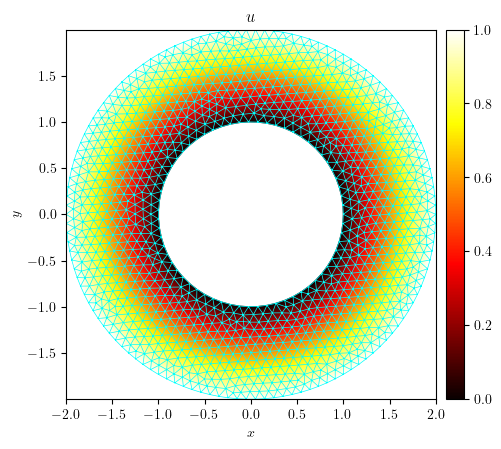

: 

In [ ]:
mesh_tri = triangulation(mesh)
u_tri = triangulation(u)
x, y = mesh_tri.x, mesh_tri.y
mesh_tri.set_mask(np.hypot(np.mean(x[mesh_tri.triangles], axis=1), np.mean(y[mesh_tri.triangles], axis=1)) < Rinner)

fig, ax = plot_colormap((x, y, u_tri), cartesian=False, triangles=mesh_tri.triangles)
plot_mesh(fig, ax, mesh, title='$u$', color='cyan', linewidth=0.5)
write(fig, f'A08_poisson_annulus', './figures', close=False, pickle=False)

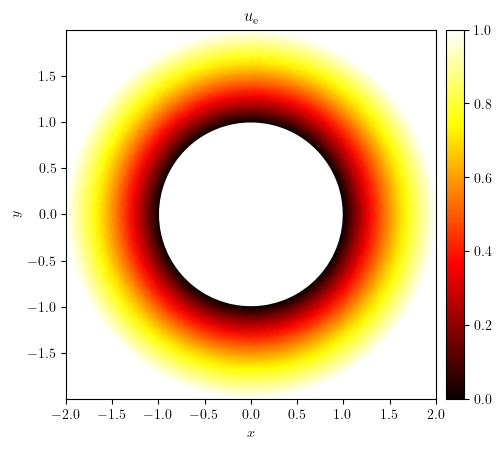

In [ ]:
def u_exact(x, y, Rinner, Router):
    r = np.sqrt(x**2 + y**2)
    return np.log(r / Rinner) / np.log(Router / Rinner)

ue = [u_exact(xi, yi, Rinner, Router) for xi, yi in zip(x, y)]

fig, ax = plot_colormap((x, y, ue), title='$u_{\mathrm{exact}}$', cartesian=False, triangles=mesh_tri.triangles)

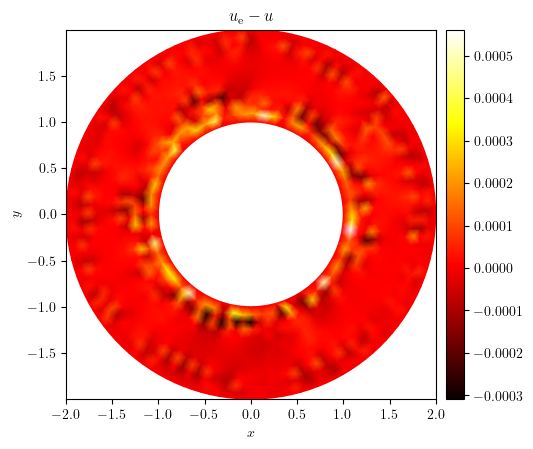

In [ ]:
error = np.subtract(ue, u_tri)
fig, ax = plot_colormap((x, y, error), title='$u_{\mathrm{exact}} - u$', cartesian=False, triangles=mesh_tri.triangles)